# The Penguin Dataset

Below is the Palmer Penguins data set collected by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER. The data contains physiological measurements for a number of penguins from each of three species of penguin: chinstrap, gentoo, and adelie.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,27,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N46A1,Yes,11/29/07,44.5,14.3,216.0,4100.0,NaN,7.96621,-25.69327,NaN
1,PAL0708,22,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N41A2,Yes,11/27/07,45.1,14.5,215.0,5000.0,FEMALE,7.63220,-25.46569,NaN
2,PAL0910,124,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N67A2,Yes,11/16/09,41.4,18.5,202.0,3875.0,MALE,9.59462,-25.42621,NaN
3,PAL0910,146,Adelie Penguin (Pygoscelis adeliae),Anvers,Dream,"Adult, 1 Egg Stage",N82A2,Yes,11/16/09,39.0,18.7,185.0,3650.0,MALE,9.22033,-26.03442,NaN
4,PAL0708,24,Chinstrap penguin (Pygoscelis antarctica),Anvers,Dream,"Adult, 1 Egg Stage",N85A2,No,11/28/07,50.6,19.4,193.0,3800.0,MALE,9.28153,-24.97134,NaN


## Preparing our dataset

Our data frame has some columns we can't use directly. Thus, we used the "one-hot encoding" to represent these features as binary columns.

In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

In [3]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1
4,50.6,19.4,193.0,3800.0,9.28153,-24.97134,0,1,0,1,1,0,0,1
5,33.1,16.1,178.0,2900.0,9.04218,-26.15775,0,1,0,1,0,1,1,0


## Looking at body mass and sex in the 3 species

The displayed figure below shows the general relationship between sex and body mass (g) in each of the 3 penguin species. By looking at the figure, it's clear that female penguins tend to have a lower body mass than the male penguins. In addition, the Gentoo penguins have a larger overall body mass than the other 2 species, weighing between 4000 to 6000 grams. Both the Adelie and Chinstap species weigh between 3000 to 4500 grams. 

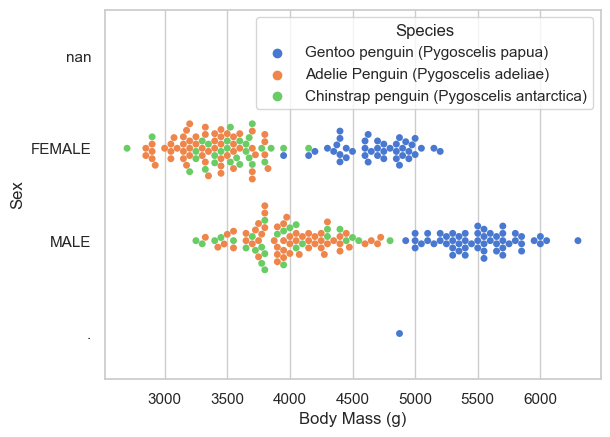

In [4]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=train, x="Body Mass (g)", y="Sex", hue="Species")
ylab = ax.set(ylabel="Sex")

## Comparing flipper lengths of the 3 species

The table below shows clear differences in flipper lengths between the 3 species. Gentoo penguins have the largest overall flipper length at 217.65mm. The Chinstrap penguins' overall flipper length comes in at 195.46mm. Adelie penguins have the smallest overall flipper length of the 3 species, at 189.97mm. However, it's important to note that there was much less data recorded for the Chinstrap species as compared to the other 2 species. 

In [5]:
train.groupby(['Species'])[['Flipper Length (mm)']].aggregate([np.mean,len ]).round(2)

Flipper Length (mm)     
                                                         mean  len
Species                                                           
Adelie Penguin (Pygoscelis adeliae)                    189.97  118
Chinstrap penguin (Pygoscelis antarctica)              195.46   56
Gentoo penguin (Pygoscelis papua)                      217.65  101

# Modeling

Below, we perform an exhaustive search of all the features contained in the dataset to find the 3 best features that will achieve 100% accuracy. The models that we will implement are Logistic Regression, Random Forest Classifier and  Decision Tree Classifier, all of which are taken from sklearn. 

In [6]:
#some parts of the code was provided by Professor Phil

from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings

warnings.filterwarnings("ignore")

all_qual_cols = ["Clutch Completion", "Sex", "Island"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

best_score_LR = 0              #highest accuracy reached with LR model
best_score_RF = 0              #highest accuracy reached with RF model
best_score_DT = 0              #highest accuracy reached with DT model

for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = list(pair) + qual_cols 
    
    #  train on logistic regression
    LR = LogisticRegression()
    LR.fit(X_train[cols], y_train)

    # keeping the list of columns for the model that has the best score 
    if (LR.score(X_train[cols], y_train) > best_score_LR):
       best_cols_LR = cols
       best_score_LR = LR.score(X_train[cols], y_train)
       best_LR = LR

    # train on random forest classifier
    RF = RandomForestClassifier(max_depth=3, random_state=0)
    RF.fit(X_train[cols], y_train)

    # keeping the list of columns for the model that has the best score 
    if (RF.score(X_train[cols], y_train) > best_score_RF):
       best_cols_RF = cols
       best_score_RF = RF.score(X_train[cols], y_train)
       best_RF = RF

   # train on decision tree classifier
    DT = DecisionTreeClassifier(max_depth=3)
    DT.fit(X_train[cols], y_train)

    # keeping the list of columns for the model that has the best score 
    if (DT.score(X_train[cols], y_train) > best_score_DT):
       best_cols_DT = cols
       best_score_DT = DT.score(X_train[cols], y_train)
       best_DT = DT

print("Best 3 columns for LR: " + str(best_cols_LR))
print("Training Accuracy for LR: " + str(best_score_LR))

print("\nBest 3 columns for RF: " + str(best_cols_RF))
print("Training Accuracy for RF: " + str(best_score_RF))

print("\nBest 3 columns for DT: " + str(best_cols_DT))
print("Training Accuracy for DT: " + str(best_score_DT))


Best 3 columns for LR: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Training Accuracy for LR: 1.0

Best 3 columns for RF: ['Culmen Length (mm)', 'Flipper Length (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Training Accuracy for RF: 0.9921875

Best 3 columns for DT: ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']
Training Accuracy for DT: 0.9921875


## Cross-Validation

We will use cross-validation to get a sense for what max depth we should set for the Decision Tree Classifier. 

In [7]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_DT, X_train[best_cols_DT], y_train, cv=5)
cv_scores

array([1.        , 0.94117647, 0.98039216, 0.98039216, 0.98039216])

In [8]:
#code provided by Professor Phil; taken from class lecture
max_depth = 5

while max_depth != 0:
  DT = DecisionTreeClassifier(max_depth = max_depth)
  cv_scores = cross_val_score(DT, X_train[best_cols_DT], y_train, cv=5)
  mean_score = cv_scores.mean()
  print(f"Max depth = {max_depth}, score = {mean_score.round(3)}")
  max_depth += -1

Max depth = 5, score = 0.98
Max depth = 4, score = 0.98
Max depth = 3, score = 0.976
Max depth = 2, score = 0.945
Max depth = 1, score = 0.731


## Plotting Decision Regions 

In [9]:
#Code provided by Professor Phil; taken from lecture notes.
from matplotlib.patches import Patch

warnings.filterwarnings("ignore")

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

Plotting decision regions for the Logistic Regression model on its 3 best chosen features: culmen length, culmen depth, and island. 

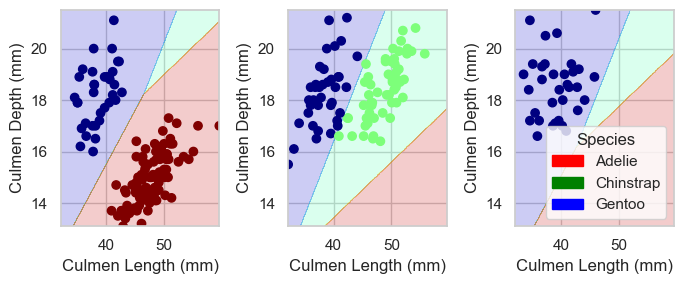

In [10]:
plot_regions(best_LR, X_train[best_cols_LR], y_train)

Plotting decision regions for the Random Forest classifier on its 3 best chosen features: culmen length, flipper length, and island. 

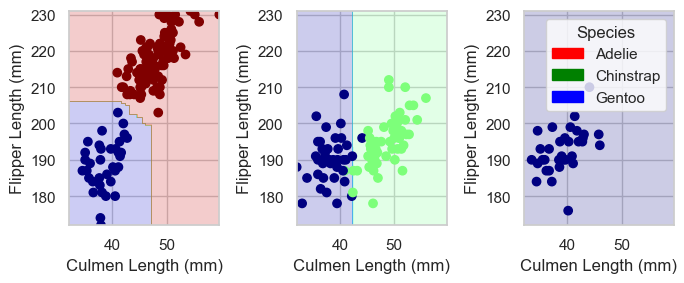

In [11]:
plot_regions(best_RF, X_train[best_cols_RF], y_train)

Plotting decision regions for the Decision Tree classifier on its 3 best chosen features: culmen length, flipper length, and island. 

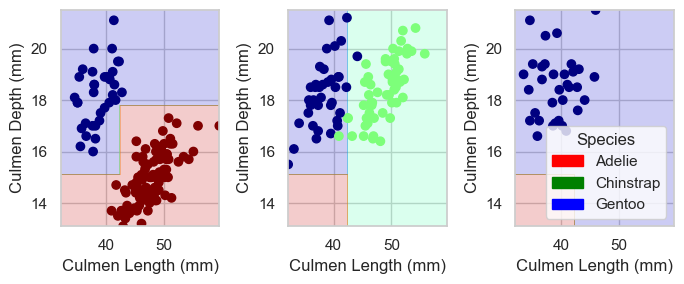

In [12]:
plot_regions(best_DT, X_train[best_cols_DT], y_train)

# Testing 

Since the Logistic Regression model yields the highest accuracy, we will use that on our test data. 

In [13]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)

print ("Testing accuracy for Logistic Regression: " + str(best_LR.score(X_test[best_cols_LR], y_test)))

Testing accuracy for Logistic Regression: 1.0


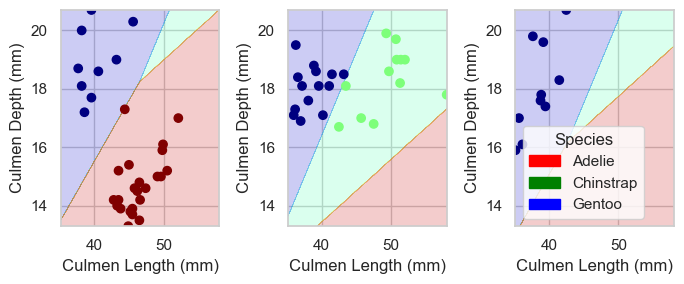

In [14]:
plot_regions(best_LR, X_test[best_cols_LR], y_test)
plt.savefig("image.jpg")